In [1]:
# Import libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Keypoints using MP Holistic


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

## Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    #pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

## Setup Folders for Collections

In [46]:
import os

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Dataset3') 

# Actions that we try to detect
actions = np.array(['Asteroide', 'Astronomia', 'Big_bang', 'Cometa', 'Ecliptica', 'Ecuador_celeste', 
                    'Meteorito', 'Meteoro', 'Meteoroide', 'Zodiaco'])

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 30

In [34]:
for action in actions: 
    for sequence in range(30, 60):#range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [24]:
actions

['test']

In [35]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(30, 60):#range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(30, 60):#range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [38]:
label_map = {label:num for num, label in enumerate(actions)}

In [39]:
label_map

{'Asteroide': 0,
 'Astronomia': 1,
 'Big_bang': 2,
 'Cometa': 3,
 'Ecliptica': 4,
 'Ecuador_celeste': 5,
 'Meteorito': 6,
 'Meteoro': 7,
 'Meteoroide': 8,
 'Zodiaco': 9}

In [51]:
no_sequences = 60

In [52]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset3\\Asteroide\\30\\0.npy'

In [44]:
len(sequences)

300

In [41]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [42]:
X_train.shape

(270, 30, 126)

## NN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [26]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(actions), activation='softmax'))

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 126)))
model.add(Dropout(0.4))  # Increased dropout

model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

e:\UdeA\Aprendizaje-estadistico\LSC_Astronophysics\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2, callbacks=[tb_callback, early_stop])

Epoch 1/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.8372 - loss: 0.5143 - val_categorical_accuracy: 0.8333 - val_loss: 0.3530
Epoch 2/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.8026 - loss: 0.5416 - val_categorical_accuracy: 0.8519 - val_loss: 0.4158
Epoch 3/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.7502 - loss: 0.7757 - val_categorical_accuracy: 0.8519 - val_loss: 0.4581
Epoch 4/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.7929 - loss: 0.7134 - val_categorical_accuracy: 0.8704 - val_loss: 0.4580
Epoch 5/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7593 - loss: 0.6568 - val_categorical_accuracy: 0.7963 - val_loss: 0.4382
Epoch 6/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8178 - loss: 0.8476 - val_categorical_accuracy: 0.7778 - val_loss: 0.8018
Epoch 7/2000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.7466 - loss: 0.88

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,992 (988.25 KB)

 Trainable params: 84,330 (329.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,662 (658.84 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


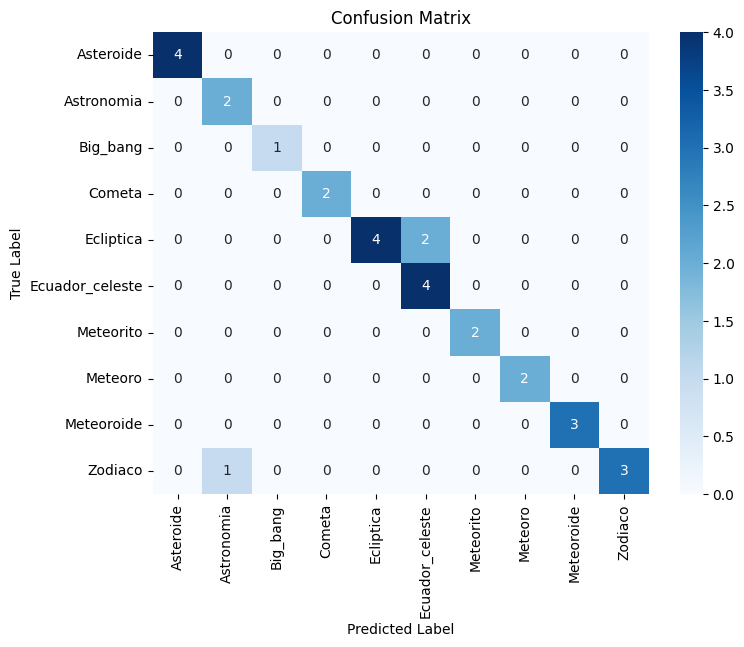

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded y_test back to class indices
y_test_indices = np.argmax(y_test, axis=1)  # Convert y_test to labels

# Compute confusion matrix
cm = confusion_matrix(y_test_indices, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=actions, yticklabels=actions)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [33]:
model.save('model_lsc_10signs.h5')

## Real time test

In [37]:
actions

array(['Asteroide', 'Astronomia', 'Big_bang', 'Cometa', 'Ecliptica',
       'Ecuador_celeste', 'Meteorito', 'Meteoro', 'Meteoroide', 'Zodiaco'],
      dtype='<U15')

In [6]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load the trained model
model = tf.keras.models.load_model("models/model_lsc_10signs.h5")

# Define class labels (Ensure this matches your training classes)
actions = np.array(['Asteroide', 'Astronomia', 'Big_bang', 'Cometa', 'Ecliptica', 'Ecuador_celeste', 
                    'Meteorito', 'Meteoro', 'Meteoroide', 'Zodiaco'])

# Initialize MediaPipe Hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# # Function to extract keypoints
def extract_keypoints(results):
    #pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

# Function to visualize probability bars
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 300), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, f"{actions[num]}: {prob:.2f}", (10, 85 + num * 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

# Define colors for probability bars
colors = [
    (245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 255), 
    (255, 165, 0), (255, 0, 255), (0, 255, 0), (128, 0, 128), (0, 128, 255)
]

# Start webcam capture
cap = cv2.VideoCapture(0)

# Initialize sequence storage
sequence = []
threshold = 0.5  # Confidence threshold for predictions

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(rgb_frame)

        # Draw landmarks on the frame
        #mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Extract keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)

        # Keep only the last 30 frames
        sequence = sequence[-30:]

        # Perform prediction when we have 30 frames
        if len(sequence) == 30:
            input_data = np.expand_dims(np.array(sequence), axis=0)  # Shape (1, 30, 1662)
            predictions = model.predict(input_data)[0]  # Get probability distribution
            predicted_class = np.argmax(predictions)  # Get the highest probability class
            confidence = predictions[predicted_class]

            # Only display the prediction if confidence is above threshold
            if confidence > threshold:
                cv2.putText(frame, f"Prediction: {actions[predicted_class]} ({confidence:.2f})", 
                            (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Display probability visualization
            frame = prob_viz(predictions, actions, frame, colors)

        # Show the webcam feed with predictions
        cv2.imshow("Real-Time Sign Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
            break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━